In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm #progress bar
import rdkit
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
rdkit.__version__


/Users/NathanJiang/opt/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2023.03.2'

In [2]:
import xgboost
import sklearn
import tensorflow as tf
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split #ML training
from sklearn.model_selection import RandomizedSearchCV
#from yellowbrick.regressor import prediction_error, ResidualsPlot
from tdc.single_pred import ADME
from tdc.benchmark_group import admet_group
from tdc import BenchmarkGroup
import warnings
warnings.filterwarnings("ignore")

2023-08-26 04:18:01.649754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def pred_prob_to_score(pred_prob):
    res = []
    for i in range(len(pred_prob)):
        res.append(pred_prob[i][1])
    res = np.array(res)
    return res

In [4]:
group = admet_group(path = 'data/')

pred_valid_list_xgb = []
pred_valid_list_rf = []
pred_valid_list_svm = []
pred_valid_list_adb = []
pred_valid_list_cnn = []
        
pred_test_list_xgb = []
pred_test_list_rf = []
pred_test_list_svm = []
pred_test_list_adb = []
pred_test_list_cnn = []

best_params_list_xgb = []
best_params_list_svm = []

for seed in [1, 2, 3, 4, 5]:
    pred_valid_xgb = {}
    pred_valid_rf = {}
    pred_valid_svm = {}
    pred_valid_adb = {}
    pred_valid_cnn = {}

    pred_test_xgb = {}
    pred_test_rf = {}
    pred_test_svm = {}
    pred_test_adb = {}
    pred_test_cnn = {}

    benchmark = group.get('hERG')
    name = benchmark['name']
    train_val, test = benchmark['train_val'], benchmark['test']
    train, valid = group.get_train_valid_split(benchmark = name, split_type = 'default', seed = seed)

    PandasTools.AddMoleculeColumnToFrame(train, smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in train['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = train['Y']
    train = pd.DataFrame(ecfp6_bits, index = train.Drug, columns=ecfp6_name).reset_index(drop = False)
    train['Y'] = Y

    PandasTools.AddMoleculeColumnToFrame(valid, smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in valid['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = valid['Y']
    valid = pd.DataFrame(ecfp6_bits, index = valid.Drug, columns=ecfp6_name).reset_index(drop = False)
    valid['Y'] = Y

    PandasTools.AddMoleculeColumnToFrame(benchmark['test'], smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in benchmark['test']['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = benchmark['test']['Y']
    benchmark['test'] = pd.DataFrame(ecfp6_bits, index = benchmark['test'].Drug, columns=ecfp6_name).reset_index(drop = False)
    benchmark['test']['Y'] = Y

    train_X = train.drop(columns = ["Drug","Y"])
    train_y = train.Y
    valid_X = valid.drop(columns = ["Drug","Y"])
    globals()['valid_y_%s'%seed] = valid.Y
    test_X = benchmark['test'].drop(columns = ["Drug","Y"])
    test_y = benchmark['test'].Y


    #XGBoost + Morgan
    xgb_parameters = {'objective':['binary:logistic'],
    'booster':['gbtree','gblinear'],
    'learning_rate': [0.1],
    'max_depth': [7,10,15,20],
    'min_child_weight': [10,15,20,25],
    'colsample_bytree': [0.8, 0.9, 1],
    'n_estimators': [300,400,500,600],
    "reg_alpha"   : [0.5,0.2,1],
    "reg_lambda"  : [2,3,5],
    "gamma"       : [1,2,3]}

    xgb_model = XGBClassifier()
    grid_obj_xgb = RandomizedSearchCV(xgb_model, xgb_parameters, cv=5, n_iter=15, scoring = 'roc_auc', verbose=5, n_jobs=1)
    grid_obj_xgb.fit(train_X, train_y, verbose = 1)
    y_pred_valid_xgb = grid_obj_xgb.predict_proba(valid_X)
    y_pred_test_xgb = grid_obj_xgb.predict_proba(test_X)
    pred_valid_xgb[name] = pred_prob_to_score(y_pred_valid_xgb)
    pred_valid_list_xgb.append(pred_valid_xgb)
    pred_test_xgb[name] = pred_prob_to_score(y_pred_test_xgb)
    pred_test_list_xgb.append(pred_test_xgb)
    bp_xgb = grid_obj_xgb.best_params_
    best_params_list_xgb.append(bp_xgb)

    #Random Forest + Morgan
    rf_model = RandomForestClassifier()
    rf_model.fit(train_X, train_y)
    y_pred_valid_rf = rf_model.predict_proba(valid_X)
    y_pred_test_rf = rf_model.predict_proba(test_X)
    pred_valid_rf[name] = pred_prob_to_score(y_pred_valid_rf)
    pred_valid_list_rf.append(pred_valid_rf)
    pred_test_rf[name] = pred_prob_to_score(y_pred_test_rf)
    pred_test_list_rf.append(pred_test_rf)

    #SVM + Morgan
    svm_parameters = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    }
    svm_model = SVC(kernel="rbf", probability=True)
    grid_obj_svm = RandomizedSearchCV(svm_model, svm_parameters, cv=5, n_iter=15, verbose=5, n_jobs=1)
    grid_obj_svm.fit(train_X, train_y)
    y_pred_valid_svm = grid_obj_svm.predict_proba(valid_X)
    y_pred_test_svm = grid_obj_svm.predict_proba(test_X)
    pred_valid_svm[name] = pred_prob_to_score(y_pred_valid_svm)
    pred_valid_list_svm.append(pred_valid_svm)
    pred_test_svm[name] = pred_prob_to_score(y_pred_test_svm)
    pred_test_list_svm.append(pred_test_svm)
    bp_svm = grid_obj_svm.best_params_
    best_params_list_svm.append(bp_svm)

    # AdaBoost + Morgan
    DTC = DecisionTreeClassifier(max_depth=4)
    adb_model = AdaBoostClassifier(n_estimators=300, base_estimator=DTC, learning_rate=1)
    adb_model.fit(train_X, train_y)
    y_pred_valid_adb = adb_model.predict_proba(valid_X)
    y_pred_test_adb = adb_model.predict_proba(test_X)
    pred_valid_adb[name] = pred_prob_to_score(y_pred_valid_adb)
    pred_valid_list_adb.append(pred_valid_adb)
    pred_test_adb[name] = pred_prob_to_score(y_pred_test_adb)
    pred_test_list_adb.append(pred_test_adb)

    #CNN + Morgan
    train_X_cnn = train_X.to_numpy()
    valid_X_cnn = valid_X.to_numpy()
    test_X_cnn = test_X.to_numpy()
    train_X_cnn = train_X_cnn.reshape(train_X_cnn.shape[0], train_X_cnn.shape[1], 1)
    valid_X_cnn = valid_X_cnn.reshape(valid_X_cnn.shape[0], valid_X_cnn.shape[1], 1)
    test_X_cnn = test_X_cnn.reshape(test_X_cnn.shape[0], test_X_cnn.shape[1], 1)
    train_X = train_X.astype('float32')
    valid_X = valid_X.astype('float32')
    test_X = test_X.astype('float32')
    cnn_model = Sequential()
    cnn_model.add(Conv1D(32, 2, padding="valid", activation="relu", input_shape=(1024,1)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64, activation="relu"))
    cnn_model.add(Dense(1,activation='sigmoid'))
    cnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives()])
    cnn_model.fit(train_X_cnn, train_y, batch_size=12, epochs=10, verbose=0)
    y_pred_valid_cnn = cnn_model.predict(valid_X_cnn)
    y_pred_test_cnn = cnn_model.predict(test_X_cnn)
    y_pred_valid_cnn_copy = []
    for i in range(len(y_pred_valid_cnn)):
        y_pred_valid_cnn_copy.append(y_pred_valid_cnn[i][0])
    y_pred_test_cnn_copy = []
    for i in range(len(y_pred_test_cnn)):
        y_pred_test_cnn_copy.append(y_pred_test_cnn[i][0])
    pred_valid_cnn[name] = np.array(y_pred_valid_cnn_copy)
    pred_valid_list_cnn.append(pred_valid_cnn)
    pred_test_cnn[name] = np.array(y_pred_test_cnn_copy)
    pred_test_list_cnn.append(pred_test_cnn)

xgb_perform = group.evaluate_many(pred_test_list_xgb)
rf_perform = group.evaluate_many(pred_test_list_rf)
svm_perform = group.evaluate_many(pred_test_list_svm)
adb_perform = group.evaluate_many(pred_test_list_adb)
cnn_perform = group.evaluate_many(pred_test_list_cnn)


Found local copy...
generating training, validation splits...
100%|██████████| 523/523 [00:00<00:00, 1630.56it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[04:18:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=300, objective=binary:logistic, reg_alpha=0.2, reg_lambda=5;, score=0.500 total time=  11.0s
[04:18:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=300, objective=binary:logistic, reg_alpha=0.2, reg_lambda=5;, score=0.500 total time=  14.8s
[04:18:34] WARNING: /Users/runn

2023-08-26 04:59:11.207116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


5/5 [==============================] - 0s 4ms/step


generating training, validation splits...
100%|██████████| 523/523 [00:00<00:00, 1925.16it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[04:59:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=500, objective=binary:logistic, reg_alpha=1, reg_lambda=3;, score=0.500 total time=  23.7s
[04:59:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=500, objective=binary:logistic, reg_alpha=1, reg_lambda=3;, score=0.500 total time=  23.6s
[05:00:03] WARNING: /Users/runner/w

generating training, validation splits...
100%|██████████| 523/523 [00:00<00:00, 1995.19it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=20, n_estimators=600, objective=binary:logistic, reg_alpha=0.2, reg_lambda=2;, score=0.773 total time= 1.0min
[CV 2/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=20, n_estimators=600, objective=binary:logistic, reg_alpha=0.2, reg_lambda=2;, score=0.838 total time= 1.5min
[CV 3/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=20, n_estimators=600, objective=binary:logistic, reg_alpha=0.2, reg_lambda=2;, score=0.704 total time= 1.1min
[CV 4/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=20, n_estimators=600, objective=binary:logistic, reg_alpha=0.2, reg_lambda=2;, score=0.708 total time= 1.1min
[CV 5/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate

generating training, validation splits...
100%|██████████| 523/523 [00:00<00:00, 1976.47it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=600, objective=binary:logistic, reg_alpha=0.2, reg_lambda=3;, score=0.700 total time=  58.9s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=600, objective=binary:logistic, reg_alpha=0.2, reg_lambda=3;, score=0.851 total time= 1.2min
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=600, objective=binary:logistic, reg_alpha=0.2, reg_lambda=3;, score=0.849 total time= 1.4min
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=600, objective=binary:logistic, reg_alpha=0.2, reg_lambda=3;, score=0.632 total time= 1.1min
[CV 5/5] END booster=gbtree, colsample_bytree=0.8, gamma=2,

generating training, validation splits...
100%|██████████| 523/523 [00:00<00:00, 1708.13it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=10, min_child_weight=15, n_estimators=300, objective=binary:logistic, reg_alpha=1, reg_lambda=2;, score=0.799 total time=  47.4s
[CV 2/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=10, min_child_weight=15, n_estimators=300, objective=binary:logistic, reg_alpha=1, reg_lambda=2;, score=0.753 total time=  57.7s
[CV 3/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=10, min_child_weight=15, n_estimators=300, objective=binary:logistic, reg_alpha=1, reg_lambda=2;, score=0.821 total time=  45.0s
[CV 4/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=10, min_child_weight=15, n_estimators=300, objective=binary:logistic, reg_alpha=1, reg_lambda=2;, score=0.668 total time=  45.2s
[CV 5/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1

In [5]:
print("xgb_perform:", xgb_perform, "\n rf_perform:", rf_perform, "\n svm_perform:", svm_perform, "\n adb_perform:", adb_perform, "\n cnn_perform:", cnn_perform)

xgb_perform: {'herg': [0.797, 0.03]} 
 rf_perform: {'herg': [0.782, 0.014]} 
 svm_perform: {'herg': [0.76, 0.032]} 
 adb_perform: {'herg': [0.787, 0.03]} 
 cnn_perform: {'herg': [0.677, 0.028]}


In [6]:
y_test = benchmark['test'].Y
y_test = np.array(y_test)


In [7]:
def rank_object(array): # convert scores into ranks
    arg_a = np.argsort(array)
    b = np.flip(np.arange(len(arg_a)))
    a = np.zeros_like(arg_a)
    for i in range(len(arg_a)):
        a[arg_a[i]] = b[i]
    return a

In [8]:
def score_to_rank(array):
  res = np.argsort(np.flip(np.argsort(array)))+1
  return res

In [9]:
def normalize(array): # define function for normalization of scores
    maximum = np.max(array)
    minimum = np.min(array)
    norm_list = []
    for i in range(len(array)):
        norm_list.append((array[i]-minimum)/(maximum-minimum))
    return np.array(norm_list)

In [10]:
predictions_valid_xgb = []
predictions_valid_rf = []
predictions_valid_svm = []
predictions_valid_adb = []
predictions_valid_cnn = []

predictions_test_xgb = []
predictions_test_rf = []
predictions_test_svm = []
predictions_test_adb = []
predictions_test_cnn = []

scoreSys = ['xgb', 'rf', 'svm', 'adb', 'cnn']

for sys in scoreSys:
  for seed in range(len(globals()['pred_valid_list_%s' % sys])):
    globals()['predictions_valid_%s' % sys].append(list(globals()['pred_valid_list_%s' % sys][seed].values())[0])

for sys in scoreSys:
  for seed in range(len(globals()['pred_test_list_%s' % sys])):
    globals()['predictions_test_%s' % sys].append(list(globals()['pred_test_list_%s' % sys][seed].values())[0])

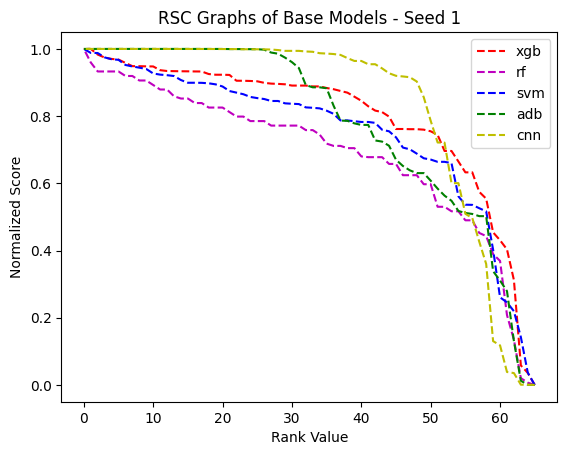

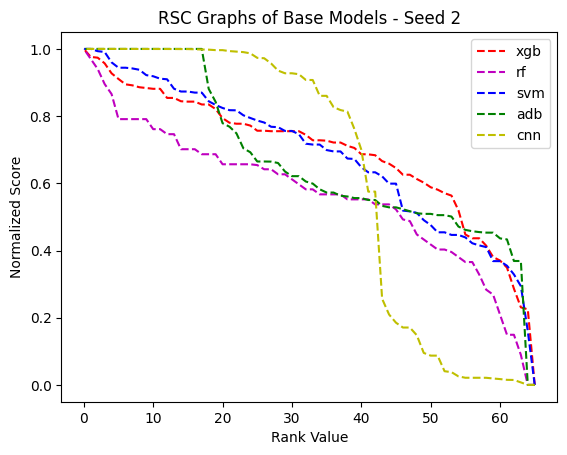

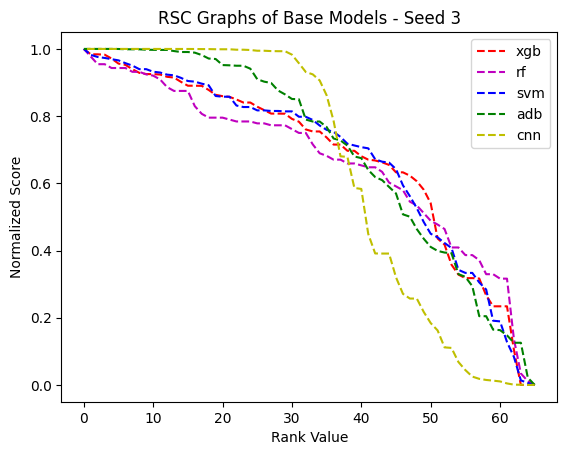

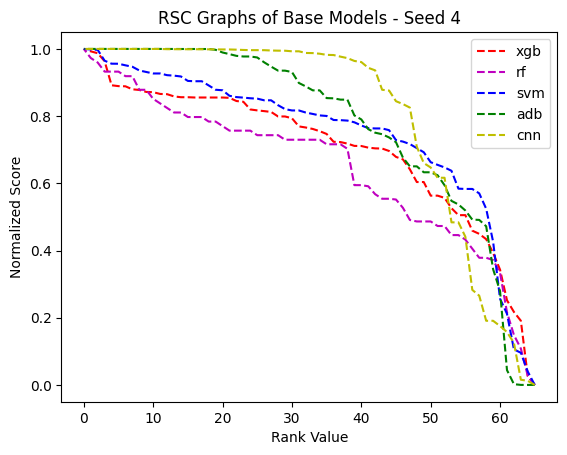

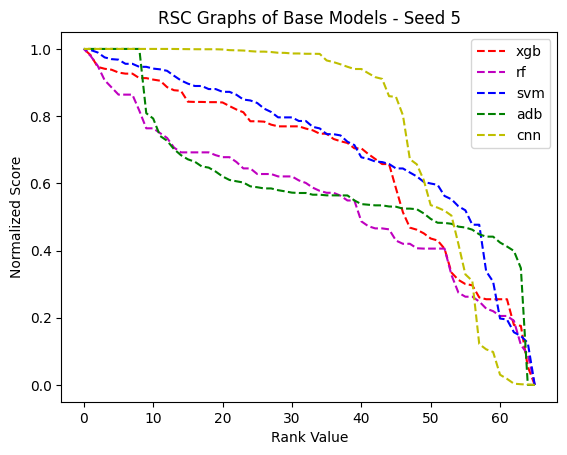

In [11]:
# RSC graphs
colors = ['r--', 'm--', 'b--', 'g--', 'y--']

for seed in range(len(globals()['predictions_valid_%s' % sys])):
  ranks = np.flip(np.arange(len(predictions_valid_xgb[seed])))
  fig, ax = plt.subplots()
  for z in range(len(scoreSys)):
    globals()['line%s' % (z+1)] = plt.plot(ranks, np.sort(normalize(globals()['predictions_valid_%s' % scoreSys[z]][seed])), colors[z], label = scoreSys[z])
    plt.legend(loc = 'upper right')
    plt.title('RSC Graphs of Base Models - Seed %s' % str(seed+1))
    plt.xlabel('Rank Value')
    plt.ylabel('Normalized Score')
  plt.show()
  image_name = benchmark['name'] + '_morgan_rsc_seed_%s'% str(seed+1) + '.png'
  image_format = 'png'
  fig.savefig(image_name, format=image_format, dpi=1200)


In [12]:
ds_score = [[] for _ in range(5)]
for sys in scoreSys:
  for seed in range(len(ds_score)):
    loc = scoreSys.index(sys)
    scoreSys.remove(sys)
    ds = 0
    for i in range(len(scoreSys)):
      ds += np.sum(np.square(normalize(np.sort(globals()['predictions_valid_%s' % sys][seed]))-normalize(np.sort(globals()['predictions_valid_%s' % scoreSys[i]][seed]))))
    ds = ds/len(scoreSys)
    scoreSys.insert(loc, sys)
    ds_score[seed].append(ds)

In [13]:
ds_score

[[0.6543802731256563,
  1.1436512021623955,
  0.5504994785767403,
  0.7040591057083058,
  1.3858597762822074],
 [1.7538766280216092,
  2.102199007473228,
  1.3618327444484315,
  1.89922721549742,
  4.608014757401239],
 [0.7349259045382405,
  0.9830580145761125,
  0.6584191460890052,
  0.6333664738741773,
  2.1695492209098726],
 [0.7837839403879434,
  1.4814986674317674,
  0.7167265180152591,
  0.8567344258179201,
  1.6364671572818121],
 [1.2670666964036645,
  2.3227702918049697,
  1.4933973853221656,
  2.5828820793634533,
  3.8097422134608756]]

In [14]:
ds_rank = np.reciprocal(ds_score)

In [15]:
ds_rank

array([[1.52816343, 0.87439247, 1.81653215, 1.4203353 , 0.72157372],
       [0.57016553, 0.47569236, 0.73430456, 0.52652994, 0.21701319],
       [1.36068139, 1.01723396, 1.51878937, 1.57886475, 0.46092524],
       [1.27586181, 0.67499217, 1.39523232, 1.16722285, 0.61107245],
       [0.78922444, 0.4305204 , 0.66961414, 0.3871644 , 0.26248495]])

In [16]:
def get_auroc(y_pred_proba, y_true):
  res = metrics.roc_auc_score(y_true, y_pred_proba)
  return res

In [17]:
ps_score = [[] for _ in range(5)]

In [18]:
for sys in scoreSys:
  for seed in range(len(ps_score)):
    ps = get_auroc(globals()['predictions_valid_%s' % sys][seed], globals()['valid_y_%s'%str(seed+1)])
    ps_score[seed].append(ps)

In [19]:
ps_score

[[0.74125, 0.855, 0.78125, 0.77, 0.825],
 [0.7967525195968644,
  0.7082866741321389,
  0.7094064949608062,
  0.5324748040313549,
  0.6119820828667413],
 [0.6825075834175934,
  0.795247724974722,
  0.8422649140546006,
  0.738119312436805,
  0.8372093023255814],
 [0.8085234093637454,
  0.7959183673469389,
  0.7857142857142858,
  0.7533013205282113,
  0.734093637454982],
 [0.8556505223171891,
  0.8831908831908832,
  0.7820512820512819,
  0.641025641025641,
  0.7359924026590693]]

In [20]:
def powerset(s):
    x = len(s)
    ls = []
    for i in range(1 << x):
        ls.append([s[j] for j in range(x) if (i & (1 << j))])
    return ls[1:]

models = powerset(scoreSys)

def myFunc(e):
  return len(e)

models.sort(key=myFunc)

models_list = []
for i in range(len(models)):
  if len(models[i]) == 1:
    models_list.append(models[i][0])
  elif len(models[i]) == 2:
    models_list.append(models[i][0]+'&'+models[i][1])
  elif len(models[i]) == 3:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2])
  elif len(models[i]) == 4:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2]+'&'+models[i][3])
  elif len(models[i]) == 5:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2]+'&'+models[i][3]+'&'+models[i][4])

# Perform average score combinations

In [21]:
avg_score_combine_seed1 = pd.DataFrame({'xgb':predictions_test_xgb[0], 'rf':predictions_test_rf[0], 'svm':predictions_test_svm[0], 'adb':predictions_test_adb[0], 'cnn':predictions_test_cnn[0]})
avg_score_combine_seed2 = pd.DataFrame({'xgb':predictions_test_xgb[1], 'rf':predictions_test_rf[1], 'svm':predictions_test_svm[1], 'adb':predictions_test_adb[1], 'cnn':predictions_test_cnn[1]})
avg_score_combine_seed3 = pd.DataFrame({'xgb':predictions_test_xgb[2], 'rf':predictions_test_rf[2], 'svm':predictions_test_svm[2], 'adb':predictions_test_adb[2], 'cnn':predictions_test_cnn[2]})
avg_score_combine_seed4 = pd.DataFrame({'xgb':predictions_test_xgb[3], 'rf':predictions_test_rf[3], 'svm':predictions_test_svm[3], 'adb':predictions_test_adb[3], 'cnn':predictions_test_cnn[3]})
avg_score_combine_seed5 = pd.DataFrame({'xgb':predictions_test_xgb[4], 'rf':predictions_test_rf[4], 'svm':predictions_test_svm[4], 'adb':predictions_test_adb[4], 'cnn':predictions_test_cnn[4]})

In [22]:
def avg_score_combine(models_list, single_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]) / 2
    elif len(j.split('&')) == 3:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]) / 3
    elif len(j.split('&')) == 4:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]+single_score[j.split('&')[3]]) / 4
    elif len(j.split('&')) == 5:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]+single_score[j.split('&')[3]]+single_score[j.split('&')[4]]) / 5

In [23]:
avg_score_combine(models_list, avg_score_combine_seed1)
avg_score_combine(models_list, avg_score_combine_seed2)
avg_score_combine(models_list, avg_score_combine_seed3)
avg_score_combine(models_list, avg_score_combine_seed4)
avg_score_combine(models_list, avg_score_combine_seed5)

# Perform average rank combinations

In [24]:
def score_to_rank(array):
  res = np.argsort(np.flip(np.argsort(array)))+1
  return res

In [25]:
avg_rank_combine_seed1 = pd.DataFrame({'xgb':score_to_rank(predictions_test_xgb[0]), 'rf':score_to_rank(predictions_test_rf[0]), 'svm':score_to_rank(predictions_test_svm[0]), 'adb':score_to_rank(predictions_test_adb[0]), 'cnn':score_to_rank(predictions_test_cnn[0])})
avg_rank_combine_seed2 = pd.DataFrame({'xgb':score_to_rank(predictions_test_xgb[1]), 'rf':score_to_rank(predictions_test_rf[1]), 'svm':score_to_rank(predictions_test_svm[1]), 'adb':score_to_rank(predictions_test_adb[1]), 'cnn':score_to_rank(predictions_test_cnn[1])})
avg_rank_combine_seed3 = pd.DataFrame({'xgb':score_to_rank(predictions_test_xgb[2]), 'rf':score_to_rank(predictions_test_rf[2]), 'svm':score_to_rank(predictions_test_svm[2]), 'adb':score_to_rank(predictions_test_adb[2]), 'cnn':score_to_rank(predictions_test_cnn[2])})
avg_rank_combine_seed4 = pd.DataFrame({'xgb':score_to_rank(predictions_test_xgb[3]), 'rf':score_to_rank(predictions_test_rf[3]), 'svm':score_to_rank(predictions_test_svm[3]), 'adb':score_to_rank(predictions_test_adb[3]), 'cnn':score_to_rank(predictions_test_cnn[3])})
avg_rank_combine_seed5 = pd.DataFrame({'xgb':score_to_rank(predictions_test_xgb[4]), 'rf':score_to_rank(predictions_test_rf[4]), 'svm':score_to_rank(predictions_test_svm[4]), 'adb':score_to_rank(predictions_test_adb[4]), 'cnn':score_to_rank(predictions_test_cnn[4])})

In [26]:
def avg_rank_combine(models_list, single_rank):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]) / 2
    elif len(j.split('&')) == 3:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]) / 3
    elif len(j.split('&')) == 4:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]+single_rank[j.split('&')[3]]) / 4
    elif len(j.split('&')) == 5:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]+single_rank[j.split('&')[3]]+single_rank[j.split('&')[4]]) / 5

In [27]:
avg_rank_combine(models_list, avg_rank_combine_seed1)
avg_rank_combine(models_list, avg_rank_combine_seed2)
avg_rank_combine(models_list, avg_rank_combine_seed3)
avg_rank_combine(models_list, avg_rank_combine_seed4)
avg_rank_combine(models_list, avg_rank_combine_seed5)

# Perform weighted score combination by diversity strength

In [28]:
ds_score_combine_seed1 = pd.DataFrame()
ds_score_combine_seed2 = pd.DataFrame()
ds_score_combine_seed3 = pd.DataFrame()
ds_score_combine_seed4 = pd.DataFrame()
ds_score_combine_seed5 = pd.DataFrame()

In [29]:
def ds_score_combine(models_list, single_score, ds_score_combine, ds_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])]+single_score[j.split('&')[3]]*ds_score[scoreSys.index(j.split('&')[3])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])] + ds_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])]+single_score[j.split('&')[3]]*ds_score[scoreSys.index(j.split('&')[3])]+single_score[j.split('&')[4]]*ds_score[scoreSys.index(j.split('&')[4])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])] + ds_score[scoreSys.index(j.split('&')[3])] + ds_score[scoreSys.index(j.split('&')[4])])

In [30]:
ds_score_combine(models_list, avg_score_combine_seed1, ds_score_combine_seed1, ds_score[0])
ds_score_combine(models_list, avg_score_combine_seed2, ds_score_combine_seed2, ds_score[1])
ds_score_combine(models_list, avg_score_combine_seed3, ds_score_combine_seed3, ds_score[2])
ds_score_combine(models_list, avg_score_combine_seed4, ds_score_combine_seed4, ds_score[3])
ds_score_combine(models_list, avg_score_combine_seed5, ds_score_combine_seed5, ds_score[4])

# Perform weighted rank combination by diversity strength

In [31]:
ds_rank_combine_seed1 = pd.DataFrame()
ds_rank_combine_seed2 = pd.DataFrame()
ds_rank_combine_seed3 = pd.DataFrame()
ds_rank_combine_seed4 = pd.DataFrame()
ds_rank_combine_seed5 = pd.DataFrame()

In [32]:
def ds_rank_combine(models_list, single_rank, ds_rank_combine, ds_rank):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])]+single_rank[j.split('&')[3]]*ds_rank[scoreSys.index(j.split('&')[3])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])] + ds_rank[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])]+single_rank[j.split('&')[3]]*ds_rank[scoreSys.index(j.split('&')[3])]+single_rank[j.split('&')[4]]*ds_rank[scoreSys.index(j.split('&')[4])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])] + ds_rank[scoreSys.index(j.split('&')[3])] + ds_rank[scoreSys.index(j.split('&')[4])])

In [33]:
ds_rank_combine(models_list, avg_rank_combine_seed1, ds_rank_combine_seed1, ds_rank[0])
ds_rank_combine(models_list, avg_rank_combine_seed2, ds_rank_combine_seed2, ds_rank[1])
ds_rank_combine(models_list, avg_rank_combine_seed3, ds_rank_combine_seed3, ds_rank[2])
ds_rank_combine(models_list, avg_rank_combine_seed4, ds_rank_combine_seed4, ds_rank[3])
ds_rank_combine(models_list, avg_rank_combine_seed5, ds_rank_combine_seed5, ds_rank[4])

# Perform weighted score combination by performance strength (AUROC)

In [34]:
ps_score_combine_seed1 = pd.DataFrame()
ps_score_combine_seed2 = pd.DataFrame()
ps_score_combine_seed3 = pd.DataFrame()
ps_score_combine_seed4 = pd.DataFrame()
ps_score_combine_seed5 = pd.DataFrame()

In [35]:
def ps_score_combine(models_list, single_score, ps_score_combine, ps_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])])+single_score[j.split('&')[3]]*(ps_score[scoreSys.index(j.split('&')[3])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])])+single_score[j.split('&')[3]]*(ps_score[scoreSys.index(j.split('&')[3])])+single_score[j.split('&')[4]]*(ps_score[scoreSys.index(j.split('&')[4])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])] + ps_score[scoreSys.index(j.split('&')[4])])

In [36]:
ps_score_combine(models_list, avg_score_combine_seed1, ps_score_combine_seed1, ps_score[0])
ps_score_combine(models_list, avg_score_combine_seed2, ps_score_combine_seed2, ps_score[1])
ps_score_combine(models_list, avg_score_combine_seed3, ps_score_combine_seed3, ps_score[2])
ps_score_combine(models_list, avg_score_combine_seed4, ps_score_combine_seed4, ps_score[3])
ps_score_combine(models_list, avg_score_combine_seed5, ps_score_combine_seed5, ps_score[4])

# Perform weighted rank combination by performance strength

In [37]:
ps_rank_combine_seed1 = pd.DataFrame()
ps_rank_combine_seed2 = pd.DataFrame()
ps_rank_combine_seed3 = pd.DataFrame()
ps_rank_combine_seed4 = pd.DataFrame()
ps_rank_combine_seed5 = pd.DataFrame()

In [38]:
def ps_rank_combine(models_list, single_rank, ps_rank_combine, ps_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])])+single_rank[j.split('&')[3]]*(1 / ps_score[scoreSys.index(j.split('&')[3])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])] + 1 / ps_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])])+single_rank[j.split('&')[3]]*(1 / ps_score[scoreSys.index(j.split('&')[3])])+single_rank[j.split('&')[4]]*(1 / ps_score[scoreSys.index(j.split('&')[4])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])] + 1 / ps_score[scoreSys.index(j.split('&')[3])] + 1 / ps_score[scoreSys.index(j.split('&')[4])])

In [39]:
ps_rank_combine(models_list, avg_rank_combine_seed1, ps_rank_combine_seed1, ps_score[0])
ps_rank_combine(models_list, avg_rank_combine_seed2, ps_rank_combine_seed2, ps_score[1])
ps_rank_combine(models_list, avg_rank_combine_seed3, ps_rank_combine_seed3, ps_score[2])
ps_rank_combine(models_list, avg_rank_combine_seed4, ps_rank_combine_seed4, ps_score[3])
ps_rank_combine(models_list, avg_rank_combine_seed5, ps_rank_combine_seed5, ps_score[4])

In [40]:
avg_rank_combine_seed1.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed2.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed3.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed4.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed5.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)

# Calculate AUROC

In [41]:
score_combine_list = np.hstack((np.array(avg_score_combine_seed1.columns), np.array(ds_score_combine_seed1.columns), np.array(ps_score_combine_seed1.columns)))
AUROC = pd.DataFrame(index = score_combine_list)
for i in range(1, 6):
  auroc_avg, auroc_ds, auroc_ps = [], [], []
  for col in globals()['avg_score_combine_seed%s' %i].columns:
    auroc_score = get_auroc(np.array(globals()['avg_score_combine_seed%s' %i][col]), y_test)
    auroc_avg.append(auroc_score)
  for col in globals()['ds_score_combine_seed%s' %i].columns:
    auroc_score = get_auroc(np.array(globals()['ds_score_combine_seed%s' %i][col]), y_test)
    auroc_ds.append(auroc_score)
  for col in globals()['ps_score_combine_seed%s' %i].columns:
    auroc_score = get_auroc(np.array(globals()['ps_score_combine_seed%s' %i][col]), y_test)
    auroc_ps.append(auroc_score)
  AUROC['seed'+str(i)] = np.hstack((auroc_avg, auroc_ds, auroc_ps))

In [42]:
pd.set_option('display.max_rows', None)

In [43]:
AUROC['avg_AUROC'] = AUROC.mean(axis=1)

In [44]:
AUROC.sort_values(by='avg_AUROC', ascending=False)

,seed1,seed2,seed3,seed4,seed5,avg_AUROC
xgb&svm&adb_ps,0.853166,0.841679,0.846981,0.826951,0.795434,0.832842
xgb&svm&adb,0.852872,0.836082,0.846686,0.827541,0.795729,0.831782
xgb&rf&svm&adb_ps,0.853166,0.838439,0.838733,0.821060,0.796613,0.829602
xgb&svm&adb_ds,0.852872,0.831370,0.849043,0.830191,0.783358,0.829367
xgb&rf&svm&adb,0.851105,0.836672,0.839912,0.822239,0.796318,0.829249
xgb&rf&adb_ps,0.843741,0.840206,0.834904,0.825184,0.800736,0.828954
xgb&rf&adb,0.843741,0.835199,0.836672,0.827541,0.797791,0.828189
xgb&rf&svm&adb_ds,0.850221,0.837555,0.834904,0.818409,0.796024,0.827423
xgb&rf&adb_ds,0.847275,0.834904,0.836672,0.824890,0.785714,0.825891
rf&svm&adb,0.851988,0.817526,0.836672,0.825479,0.792194,0.824772
